# 自旋处理：RHF vs UHF

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bud-primordium/AtomSCF/blob/main/docs/source/tutorials/06-spin.ipynb)

## 学习目标

- 理解限制性（RHF）与非限制性（UHF）Hartree-Fock 的区别
- 掌握 LSDA 自旋极化计算方法
- 分析开壳层体系的自旋密度分布

## RHF vs UHF 核心区别

| 方法 | 适用体系 | α/β 轨道 | 自旋极化 |
|------|----------|----------|----------|
| **RHF** | 闭壳层（He, Be, Ne） | 相同 | 无 |
| **UHF** | 开壳层（H, Li, C） | 独立 | 有 |

## 理论基础：自旋极化 DFT

自旋密度泛函理论（SDFT）区分自旋向上和向下通道。

### LSDA vs LDA

**LDA（自旋非极化）**：
- 强制 $n_\uparrow = n_\downarrow = n/2$
- 对称交换关联势：$v_{xc}^\uparrow = v_{xc}^\downarrow$

**LSDA（自旋极化）**：
- 独立密度：$n_\uparrow(r) \neq n_\downarrow(r)$
- 自旋极化度：$\zeta = (n_\uparrow - n_\downarrow)/n$
- 不对称势：$v_{xc}^\uparrow \neq v_{xc}^\downarrow$

### 自旋分裂

交换关联势的自旋依赖性导致轨道能级分裂：

$$\Delta \varepsilon = \varepsilon_\uparrow - \varepsilon_\downarrow \approx \frac{\partial^2 \varepsilon_{xc}}{\partial \zeta^2}\Delta\zeta$$

**Hund 规则**：最大自旋多重度配置能量最低（如 C: $2p^2 \rightarrow \uparrow\uparrow$ 而非 $\uparrow\downarrow$）

**代码实现**：
- `spin_mode="LSDA"` → 自旋极化计算
- `result.n_up`, `result.n_dn` → 自旋分辨密度
- `eps_by_l_sigma[(l, "up")]` → 自旋分辨能量


In [1]:
# 环境配置
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/bud-primordium/AtomSCF.git

In [2]:
# 配置中文字体（避免乱码）
import matplotlib.pyplot as plt
import matplotlib

# 跨平台中文字体配置
matplotlib.rcParams['font.sans-serif'] = [
    'Arial Unicode MS',      # macOS
    'WenQuanYi Micro Hei',  # Linux
    'SimHei',                # Windows
    'DejaVu Sans'            # Fallback
]
matplotlib.rcParams['axes.unicode_minus'] = False

# 清除字体缓存（重要！）
try:
    import matplotlib.font_manager as fm
    fm._load_fontmanager(try_read_cache=False)
except Exception:
    pass


In [3]:

import numpy as np
import matplotlib.pyplot as plt
from atomscf.grid import radial_grid_linear
from atomscf.scf import SCFConfig, run_lsda_pz81
from atomscf.scf_hf import HFSCFGeneralConfig, HFSCFGeneralResult, run_hf_scf

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 5)

# 便捷函数：安全提取轨道能量

def get_orbital_energy(result, l, spin='up', idx=0):
    eps_list = result.eps_by_l_sigma.get((l, spin), [])
    return eps_list[idx] if idx < len(eps_list) else 0.0



## 1. 闭壳层体系：He 原子

氦原子（Z=2）电子组态 1s²，两个电子自旋配对，适合 RHF。

In [4]:

# 生成网格
r, w = radial_grid_linear(n=600, rmin=1e-5, rmax=20.0)

# He: LSDA 计算（自旋非极化）
cfg_he = SCFConfig(
    Z=2,
    r=r,
    w=w,
    spin_mode='LDA',      # 强制自旋配对
)
result_he_lda = run_lsda_pz81(cfg_he)

E_total_he = result_he_lda.energies.get('E_total', 0.0) if result_he_lda.energies else 0.0
eps_1s_he = get_orbital_energy(result_he_lda, l=0, spin='up', idx=0)

print('He 原子 LDA（自旋非极化）:')
print(f'  总能量: {E_total_he:.6f} Hartree')
print(f'  1s 能级: {eps_1s_he:.6f} Hartree')



## 2. 开壳层体系：H 原子

氢原子（Z=1）只有 1 个电子，必须使用自旋极化方法。

In [5]:

# H: LSDA 自旋极化计算
cfg_h_lsda = SCFConfig(
    Z=1,
    r=r,
    w=w,
    spin_mode='LSDA',      # 自旋极化
)
result_h_lsda = run_lsda_pz81(cfg_h_lsda)

E_total_h = result_h_lsda.energies.get('E_total', 0.0) if result_h_lsda.energies else 0.0
eps_1s_up = get_orbital_energy(result_h_lsda, l=0, spin='up', idx=0)

print('H 原子 LSDA（自旋极化）:')
print(f'  总能量: {E_total_h:.6f} Hartree')
print(f'  1s↑ 能级: {eps_1s_up:.6f} Hartree')
print('  理论值: -0.5 Hartree')
print('\n自旋密度:')
print(f"  n↑ 积分: {np.sum(result_h_lsda.n_up * w * 4 * np.pi * r**2):.4f}")
print(f"  n↓ 积分: {np.sum(result_h_lsda.n_dn * w * 4 * np.pi * r**2):.4f}")



## 3. 自旋密度可视化

对比 H 原子的 α 和 β 自旋密度分布：

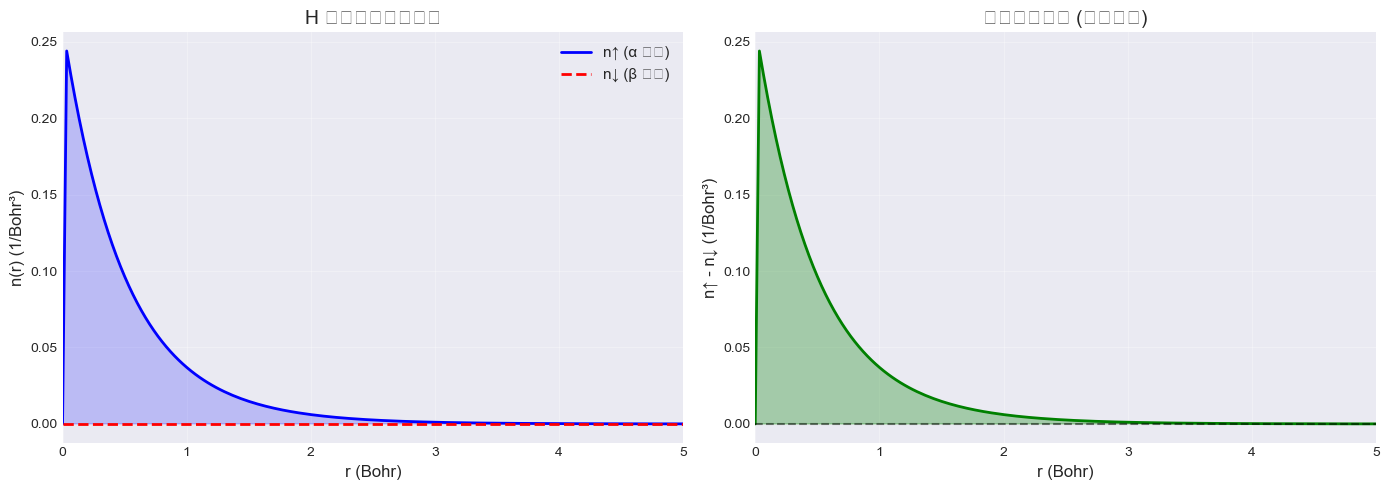

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 左图：自旋密度
ax1.plot(r, result_h_lsda.n_up, 'b-', linewidth=2, label='n↑ (α 自旋)')
ax1.plot(r, result_h_lsda.n_dn, 'r--', linewidth=2, label='n↓ (β 自旋)')
ax1.fill_between(r, result_h_lsda.n_up, alpha=0.2, color='blue')
ax1.set_xlabel('r (Bohr)', fontsize=12)
ax1.set_ylabel('n(r) (1/Bohr³)', fontsize=12)
ax1.set_title('H 原子自旋密度分布', fontsize=14)
ax1.set_xlim(0, 5)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# 右图：自旋极化密度
spin_density = result_h_lsda.n_up - result_h_lsda.n_dn
ax2.plot(r, spin_density, 'g-', linewidth=2)
ax2.fill_between(r, 0, spin_density, alpha=0.3, color='green')
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax2.set_xlabel('r (Bohr)', fontsize=12)
ax2.set_ylabel('n↑ - n↓ (1/Bohr³)', fontsize=12)
ax2.set_title('自旋极化密度 (磁化密度)', fontsize=14)
ax2.set_xlim(0, 5)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 计算磁矩
mag_moment = np.sum(spin_density * w * 4 * np.pi * r**2)
print(f"磁矩: {mag_moment:.4f} μ_B")

## 4. C 原子：开壳层多电子体系

碳原子（Z=6）电子组态 1s² 2s² 2p²，2p 壳层部分填充。

根据 **Hund 规则**：2 个 2p 电子自旋平行（↑↑），形成三重态。

In [7]:

# 网格（C 需要更多点）
r_c, w_c = radial_grid_linear(n=800, rmin=1e-5, rmax=25.0)

# C: LSDA 自旋极化
# 2p² 按 Hund 规则：2 个电子都是 ↑ 自旋
cfg_c = SCFConfig(
    Z=6,
    r=r_c,
    w=w_c,
    spin_mode='LSDA',
)
result_c = run_lsda_pz81(cfg_c)

E_total_c = result_c.energies.get('E_total', 0.0) if result_c.energies else 0.0
print('C 原子 LSDA:')
print(f'  总能量: {E_total_c:.6f} Hartree')
print('\n轨道能量 (Hartree):')
for l, label in [(0, 's'), (1, 'p')]:
    for spin, spin_mark in [('up', '↑'), ('down', '↓')]:
        eps_list = result_c.eps_by_l_sigma.get((l, spin), [])
        if not len(eps_list):
            continue
        for i, eps in enumerate(eps_list):
            print(f'  {i + l + 1}{label}{spin_mark}: {eps:.6f}')



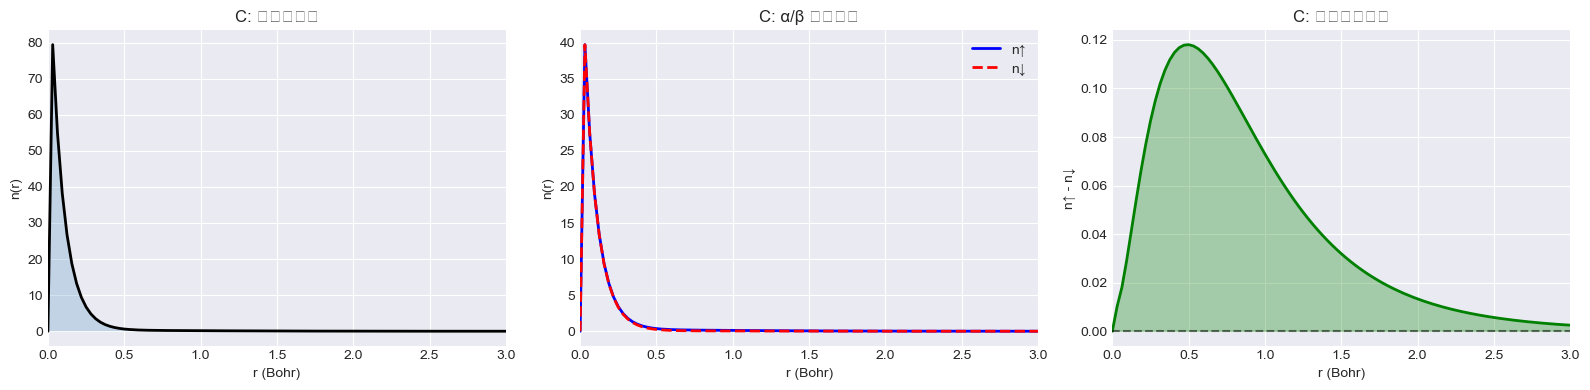

In [8]:
# C 原子自旋密度可视化
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 总密度
n_total_c = result_c.n_up + result_c.n_dn
axes[0].plot(r_c, n_total_c, 'k-', linewidth=2)
axes[0].fill_between(r_c, 0, n_total_c, alpha=0.2)
axes[0].set_xlabel('r (Bohr)')
axes[0].set_ylabel('n(r)')
axes[0].set_title('C: 总电子密度')
axes[0].set_xlim(0, 3)

# α/β 密度
axes[1].plot(r_c, result_c.n_up, 'b-', linewidth=2, label='n↑')
axes[1].plot(r_c, result_c.n_dn, 'r--', linewidth=2, label='n↓')
axes[1].set_xlabel('r (Bohr)')
axes[1].set_ylabel('n(r)')
axes[1].set_title('C: α/β 自旋密度')
axes[1].set_xlim(0, 3)
axes[1].legend()

# 自旋极化
spin_c = result_c.n_up - result_c.n_dn
axes[2].plot(r_c, spin_c, 'g-', linewidth=2)
axes[2].fill_between(r_c, 0, spin_c, alpha=0.3, color='green')
axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[2].set_xlabel('r (Bohr)')
axes[2].set_ylabel('n↑ - n↓')
axes[2].set_title('C: 自旋极化密度')
axes[2].set_xlim(0, 3)

plt.tight_layout()
plt.show()

# 验证电子数
N_up = np.sum(result_c.n_up * w_c * 4 * np.pi * r_c**2)
N_dn = np.sum(result_c.n_dn * w_c * 4 * np.pi * r_c**2)
print(f"\n电子数: N↑={N_up:.2f}, N↓={N_dn:.2f}, 总={N_up+N_dn:.2f}")
print(f"磁矩: {N_up - N_dn:.2f} μ_B")

## 5. LDA vs LSDA 对比

对于开壳层体系，强制自旋配对（LDA）会导致能量偏高：

In [9]:

# Li 原子：LDA vs LSDA
r_li, w_li = radial_grid_linear(n=600, rmin=1e-5, rmax=25.0)

# LDA（强制自旋配对）
cfg_li_lda = SCFConfig(
    Z=3, r=r_li, w=w_li,
    spin_mode='LDA',
)
result_li_lda = run_lsda_pz81(cfg_li_lda)

# LSDA（自旋极化）
cfg_li_lsda = SCFConfig(
    Z=3, r=r_li, w=w_li,
    spin_mode='LSDA',
)
result_li_lsda = run_lsda_pz81(cfg_li_lsda)

E_li_lda = result_li_lda.energies.get('E_total', 0.0) if result_li_lda.energies else 0.0
E_li_lsda = result_li_lsda.energies.get('E_total', 0.0) if result_li_lsda.energies else 0.0
delta_mHa = (E_li_lda - E_li_lsda) * 1000

print('Li 原子能量对比:')
print(f'  LDA（自旋配对）:  {E_li_lda:.6f} Hartree')
print(f'  LSDA（自旋极化）: {E_li_lsda:.6f} Hartree')
print(f'  能量差: {delta_mHa:.2f} mHartree')
print('\n结论: LSDA 能量更低，自旋极化稳定开壳层体系')



## 总结

### 方法选择指南

| 体系类型 | 电子组态 | 推荐方法 |
|----------|----------|----------|
| 闭壳层 | He(1s²), Be(2s²), Ne | RHF / LDA |
| 开壳层 | H(1s¹), Li(2s¹), C(2p²) | UHF / LSDA |

### 关键概念

- **自旋极化**：α 和 β 电子密度不同，产生磁矩
- **Hund 规则**：同一壳层电子优先自旋平行排列
- **能量稳定化**：自旋极化降低开壳层体系能量

## 下一步

→ **[07-complete-example.ipynb](07-complete-example.ipynb)**：端到端完整计算示例